- Reference
  - https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

In [1]:
from tensorflow.keras.layers import Input, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os

In [3]:
from glob import glob
import cv2
from matplotlib.pyplot import imread

In [24]:
DATA_DIR_PATH = './data'
OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '03_out')

In [25]:
os.makedirs(os.path.join(DATA_DIR_PATH, 'datasets'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [26]:
class DataLoader:
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.datasets_path = os.path.join(DATA_DIR_PATH, 'datasets')

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        glob_path = os.path.join(self.datasets_path, self.dataset_name, data_type, '*')
        img_paths = glob(glob_path)

        batch_images = np.random.choice(img_paths, size=batch_size)

        imgs_A = []
        imgs_B = []

        for img_path in batch_images:
            img = self.imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            #img_A = scipy.misc.imresize(img_A, self.img_res)
            img_A = cv2.resize(img_A, self.img_res)
            #img_B = scipy.misc.imresize(img_B, self.img_res)
            img_B = cv2.resize(img_B, self.img_res)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"

        #path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))
        glob_path = os.path.join(self.datasets_path, self.dataset_name, data_type, '*')
        img_paths = glob(glob_path)

        self.n_batches = int(len(img_paths) / batch_size)

        #for i in range(self.n_batches-1):
        for i in range(self.n_batches):
            batch = img_paths[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []

            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                #img_A = scipy.misc.imresize(img_A, self.img_res)
                img_A = cv2.resize(img_A, self.img_res)
                #img_B = scipy.misc.imresize(img_B, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, img_path):
        #return scipy.misc.imread(path, mode='RGB').astype(np.float)
        return imread(img_path).astype(np.float)

In [27]:
IMG_ROWS = 256
IMG_COLS = 256

data_loader = DataLoader('facades', img_res=(IMG_ROWS, IMG_COLS))

In [28]:
class Pix2Pix:
    def __init__(self, data_loader):
        self.history = pd.DataFrame({}, columns=['epoch', 'epochs', 'batch_idx', 'batch_num', 'd_loss', 'acc', 'g_loss', 'elapsed_time'])

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.combined_name = 'combined_model'

        # Input shape
        self.img_rows = IMG_ROWS
        self.img_cols = IMG_COLS
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        #self.dataset_name = 'facades'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))
        self.data_loader = data_loader
        self.dataset_name = self.data_loader.dataset_name

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)

        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        print(datetime.datetime.now().isoformat(), 'Start')

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size), 1):
                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                self.history = self.history.append({
                    'epoch': epoch,
                    'epochs': epochs,
                    'batch_idx': batch_i,
                    'batch_num': self.data_loader.n_batches,
                    'd_loss': d_loss[0],
                    'acc': d_loss[1],
                    'g_loss': g_loss,
                    'elapsed_time': elapsed_time
                }, ignore_index=True)
                print(datetime.datetime.now().isoformat(), '[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s' % (
                    epoch, epochs,
                    batch_i, self.data_loader.n_batches,
                    d_loss[0], 100*d_loss[1],
                    g_loss[0],
                    elapsed_time))

                # If at save interval => save generated image samples
                if sample_interval > 0 and batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_images(self, epoch, batch_i):
        dir_path = os.path.join(self.img_save_dir, self.dataset_name)

        #os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        os.makedirs(dir_path, exist_ok=True)

        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i, j].axis('off')
                cnt += 1

        #fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        file_path = os.path.join(dir_path, '%d_%d.png' % (epoch, batch_i))
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()

    def save_models(self):
        self.save_model_weights(self.combined, self.combined_name)

    def save_model_weights(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))
        model.save_weights(file_path)

        print('Model weights saved.', model_name)

    def load_models(self):
        self.load_model_weights(self.combined_name)

    def load_model_weights(self, model_name):
        model = None

        if model_name == self.combined_name:
            model = self.combined
        else:
            print('Unsupported.', model_name)
            return

        if not model:
            print('Not initialized.', model_name)
            return

        file_path = os.path.join(self.model_save_dir, self._create_h5_file_name(model_name, file_suffix))

        if not os.path.exists(file_path):
            print('File Not found.', model_name)
            return

        model.load_weights(file_path)

        print('Model weights loaded.', model_name)

    def _create_h5_file_name(self, model_name, suffix=None):
        if suffix:
            return '{}_{}.h5'.format(model_name, suffix)
        else:
            return '{}.h5'.format(model_name)

In [29]:
gan = Pix2Pix(data_loader)

In [30]:
gan.train(epochs=3, batch_size=1, sample_interval=1)

2020-07-24T23:23:41.707445 Start
2020-07-24T23:23:45.641383 [Epoch 0/3] [Batch 1/3] [D loss: 7.112707, acc:  38%] [G loss: 65.255219] time: 0:00:03.930060
2020-07-24T23:23:48.010884 [Epoch 0/3] [Batch 2/3] [D loss: 7.063773, acc:  50%] [G loss: 80.654167] time: 0:00:06.299452
2020-07-24T23:23:50.372834 [Epoch 0/3] [Batch 3/3] [D loss: 7.048609, acc:  59%] [G loss: 74.118538] time: 0:00:08.661205
2020-07-24T23:23:52.749658 [Epoch 1/3] [Batch 1/3] [D loss: 6.431103, acc:  46%] [G loss: 63.857990] time: 0:00:11.037604
2020-07-24T23:23:55.503946 [Epoch 1/3] [Batch 2/3] [D loss: 6.345591, acc:  56%] [G loss: 57.202324] time: 0:00:13.791791
2020-07-24T23:23:58.081143 [Epoch 1/3] [Batch 3/3] [D loss: 3.788973, acc:  46%] [G loss: 50.335026] time: 0:00:16.368962
2020-07-24T23:24:00.690173 [Epoch 2/3] [Batch 1/3] [D loss: 6.563043, acc:  51%] [G loss: 51.915134] time: 0:00:18.977623
2020-07-24T23:24:03.544925 [Epoch 2/3] [Batch 2/3] [D loss: 3.901158, acc:  47%] [G loss: 42.537434] time: 0:00:2

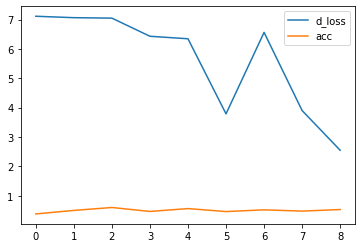

In [31]:
gan.plot_hisotry()

In [32]:
gan.save_models()

Model weights saved. combined_model
